# 第5章 ノード埋め込み


## 5.4.2 データセットのダウンロードと前処理

このセクションでは、Coraデータセットをダウンロードし、前処理を行います。

Coraデータセットは、機械学習分野の論文引用ネットワークを表すデータセットです。

各ノードは論文を表し、エッジは論文間の引用関係を表します。

### 必要なライブラリのインストール

In [1]:
!pip uninstall -y fastai torch torchaudio torchvision
!pip install torch==2.0.0+cpu --index-url https://download.pytorch.org/whl/cpu
!pip install torch-cluster torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric==2.3.1

Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.0.0%2Bcpu-cp311-cp311-linux_x86_64.whl (195.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
timm 1.0.14 requires torchvision, which is not installed.
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid

Coraデータセットをダウンロードし、その内容を確認します。

In [3]:
# torch_geometric の Dataset としてダウンロード
dataset = Planetoid(root="./dataset", name="Cora", split="full")

Processing...
Done!


In [4]:
# Planetoid は torch_geometric の InMemoryDataset を継承している
# そのため、torch_geometric での学習が容易である
print(f"データセットの型 : {type(dataset)}")
print(f"ネットワークの型 : {type(dataset._data)}")

データセットの型 : <class 'torch_geometric.datasets.planetoid.Planetoid'>
ネットワークの型 : <class 'torch_geometric.data.data.Data'>


In [5]:
from collections import Counter
from torch_geometric.utils.convert import to_networkx

# PyTorch Geometric -> NetworkX への変換
cora_network = to_networkx(dataset._data, node_attrs=["y"])
print(f"ネットワークの型 : {type(cora_network)}")
print(f"ノード数 : {cora_network.number_of_nodes():,}")
print(f"エッジ数 : {cora_network.number_of_edges():,}")

ネットワークの型 : <class 'networkx.classes.digraph.DiGraph'>
ノード数 : 2,708
エッジ数 : 10,556


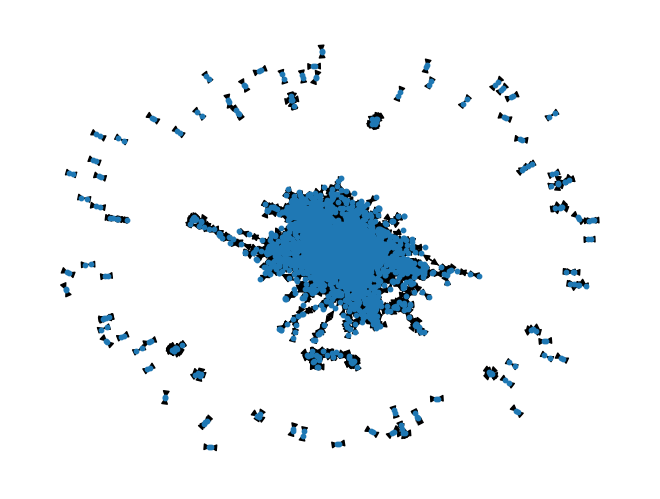

In [6]:
# Coraネットワークの描画
nx.draw(cora_network, node_size=10)

ラベル分布を表示

Coraデータセットにおける、各技術領域の論文数の分布を可視化します。

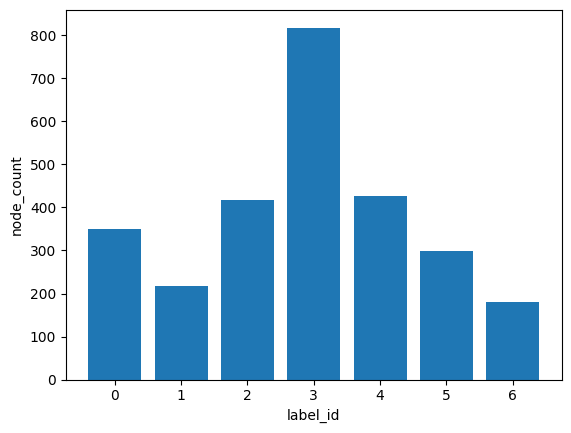

In [7]:
# 各論文の技術領域に対応するIDを取得
labels = nx.get_node_attributes(cora_network, "y")
label_counter = Counter(labels.values())

# ラベル分布を表示
plt.bar(
    [k for k, _ in sorted(label_counter.items())],
    [v for _, v in sorted(label_counter.items())],
)
plt.xlabel("label_id")
plt.ylabel("node_count")
plt.show()

ノードを学習データとテストデータに分割

Coraデータセットのノードを、学習データとテストデータに分割します。

ここでは、`RandomNodeSplit`を用いて、ランダムに分割を行います。

In [8]:
from torch_geometric.transforms import RandomNodeSplit

# ノードを学習データとテストデータに分割
node_splitter = RandomNodeSplit(
    split="train_rest",
    num_splits=1,
    num_val=0.0,
    num_test=0.4,
    key="y",
)
splitted_data = node_splitter(dataset._data)
print(splitted_data.node_attrs())
print(splitted_data.train_mask)
print(splitted_data.test_mask)

['test_mask', 'y', 'x', 'val_mask', 'train_mask']
tensor([False,  True,  True,  ...,  True,  True, False])
tensor([ True, False, False,  ..., False, False,  True])


## 5.4.3 node2vecによる分散表現の学習

このセクションでは、node2vecアルゴリズムを用いて、ノードの分散表現を学習します。

node2vecは、グラフ構造を考慮したノードの埋め込み表現を学習する手法です。

In [9]:
import torch
from torch_geometric.nn import Node2Vec

# node2vecモデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"
n2v_model = Node2Vec(
    splitted_data.edge_index,
    embedding_dim=64,
    walk_length=5,
    context_size=5,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=False,
).to(device)

# 最適化アルゴリズムの選択
n2v_optimizer = torch.optim.Adam(
    list(n2v_model.parameters()),
    lr=0.01,
)

node2vecモデルの学習を行う関数を定義します

In [10]:
from tqdm import tqdm


# node2vec の学習を行う関数の定義
def train_n2v() -> float:
    n2v_model.train()
    total_loss = 0.0

    loader = n2v_model.loader(batch_size=8, shuffle=True)

    # サンプリングしたランダムウォークの読み込み
    for pos_rw, neg_rw in tqdm(loader):
        n2v_optimizer.zero_grad()

        # 損失の計算
        loss = n2v_model.loss(
            pos_rw.to(device),
            neg_rw.to(device),
        )
        loss.backward()
        n2v_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

学習の実行

30エポック学習を行います。

In [11]:
for epoch in range(30):
    loss = train_n2v()
    print(f"train loss : {loss:.4f}")

100%|██████████| 339/339 [00:00<00:00, 346.98it/s]


train loss : 5.5452


100%|██████████| 339/339 [00:00<00:00, 373.46it/s]


train loss : 3.6855


100%|██████████| 339/339 [00:00<00:00, 388.90it/s]


train loss : 2.9281


100%|██████████| 339/339 [00:00<00:00, 392.58it/s]


train loss : 2.3977


100%|██████████| 339/339 [00:00<00:00, 398.20it/s]


train loss : 2.0328


100%|██████████| 339/339 [00:00<00:00, 392.49it/s]


train loss : 1.7418


100%|██████████| 339/339 [00:00<00:00, 405.15it/s]


train loss : 1.5170


100%|██████████| 339/339 [00:00<00:00, 402.07it/s]


train loss : 1.3421


100%|██████████| 339/339 [00:00<00:00, 415.01it/s]


train loss : 1.2140


100%|██████████| 339/339 [00:00<00:00, 400.53it/s]


train loss : 1.1142


100%|██████████| 339/339 [00:00<00:00, 377.42it/s]


train loss : 1.0377


100%|██████████| 339/339 [00:00<00:00, 344.22it/s]


train loss : 0.9869


100%|██████████| 339/339 [00:01<00:00, 288.76it/s]


train loss : 0.9482


100%|██████████| 339/339 [00:01<00:00, 273.89it/s]


train loss : 0.9211


100%|██████████| 339/339 [00:00<00:00, 400.74it/s]


train loss : 0.8995


100%|██████████| 339/339 [00:00<00:00, 400.86it/s]


train loss : 0.8874


100%|██████████| 339/339 [00:00<00:00, 402.34it/s]


train loss : 0.8773


100%|██████████| 339/339 [00:00<00:00, 388.90it/s]


train loss : 0.8732


100%|██████████| 339/339 [00:00<00:00, 400.39it/s]


train loss : 0.8700


100%|██████████| 339/339 [00:00<00:00, 401.49it/s]


train loss : 0.8711


100%|██████████| 339/339 [00:00<00:00, 399.08it/s]


train loss : 0.8700


100%|██████████| 339/339 [00:00<00:00, 388.36it/s]


train loss : 0.8691


100%|██████████| 339/339 [00:00<00:00, 399.72it/s]


train loss : 0.8733


100%|██████████| 339/339 [00:00<00:00, 358.31it/s]


train loss : 0.8744


100%|██████████| 339/339 [00:01<00:00, 250.48it/s]


train loss : 0.8766


100%|██████████| 339/339 [00:01<00:00, 293.74it/s]


train loss : 0.8776


100%|██████████| 339/339 [00:01<00:00, 278.79it/s]


train loss : 0.8775


100%|██████████| 339/339 [00:00<00:00, 369.31it/s]


train loss : 0.8773


100%|██████████| 339/339 [00:00<00:00, 392.54it/s]


train loss : 0.8792


100%|██████████| 339/339 [00:00<00:00, 395.23it/s]

train loss : 0.8782


## 5.4.4 ロジスティック回帰による論文の技術領域の分類

In [12]:
# ノードに対応するベクトルを行列形式で獲得
embedding_matrix = n2v_model.embedding(
    torch.arange(splitted_data.num_nodes)
)
print(embedding_matrix.shape)

torch.Size([2708, 64])


Coraデータセットには、論文の単語出現頻度を表す特徴量が含まれているため、
この特徴量にアクセスします。

In [13]:
# あらかじめ与えられた特徴量へのアクセス
print(splitted_data.x.shape)

torch.Size([2708, 1433])


あらかじめ与えられた特徴量を用いたロジスティック回帰モデルの学習します

このモデルは、node2vecを使用しないベースラインモデルとなります

In [14]:
# あらかじめ与えられた特徴量を用いたロジスティック回帰モデルの学習
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

baseline_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)
X_train = splitted_data.x[splitted_data.train_mask].numpy()
y_train = splitted_data.y[splitted_data.train_mask].numpy()
baseline_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

ベースラインモデルを用いて、テストデータに対する推論を行い、モデルを評価します

In [15]:
# 評価データに対する推論
X_test = splitted_data.x[splitted_data.test_mask].numpy()
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = baseline_classifier.predict(X_test)

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       149
           1       0.90      0.66      0.76        80
           2       0.91      0.84      0.87       177
           3       0.71      0.86      0.78       311
           4       0.82      0.76      0.79       169
           5       0.72      0.65      0.68       130
           6       0.66      0.57      0.61        67

    accuracy                           0.76      1083
   macro avg       0.77      0.71      0.74      1083
weighted avg       0.76      0.76      0.76      1083



続いて、ノードの分散表現を特徴量に加えたロジスティック回帰モデルの学習を行います

In [16]:
# ノードの分散表現を特徴量に加えたロジスティック回帰モデルの学習
n2v_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)
X_train = torch.cat(
    (
        splitted_data.x[splitted_data.train_mask],
        embedding_matrix[splitted_data.train_mask],
    ),
    dim=1,
).detach().numpy()
y_train = splitted_data.y[splitted_data.train_mask].numpy()
n2v_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

node2vecを用いたモデルを評価します

In [17]:
# テストデータに対する推論
X_test = torch.cat(
    (
        splitted_data.x[splitted_data.test_mask],
        embedding_matrix[splitted_data.test_mask],
    ),
    dim=1,
).detach().numpy()
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = n2v_classifier.predict(X_test)

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       149
           1       0.82      0.74      0.78        80
           2       0.89      0.90      0.90       177
           3       0.80      0.84      0.82       311
           4       0.83      0.85      0.84       169
           5       0.77      0.73      0.75       130
           6       0.73      0.70      0.72        67

    accuracy                           0.80      1083
   macro avg       0.79      0.78      0.79      1083
weighted avg       0.80      0.80      0.80      1083

